<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/Danling/Danling_390_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import time as time
warnings.filterwarnings("ignore")

In [ ]:
# load dataset
train = pd.read_csv('train_final.csv', parse_dates = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'])
# remove useless columns
train = train.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])
test = test.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])

In [ ]:
# find categorical variables
train.select_dtypes(exclude='number')

,date,location_key_x,country_code,day_name,season
0,2020-01-22,US_AK,US,Wednesday,Winter
1,2020-01-23,US_AK,US,Thursday,Winter
2,2020-01-24,US_AK,US,Friday,Winter
3,2020-01-25,US_AK,US,Saturday,Winter
4,2020-01-26,US_AK,US,Sunday,Winter
...,...,...,...,...,...
69908,2021-12-27,AU_WA,AU,Monday,Summer
69909,2021-12-28,AU_WA,AU,Tuesday,Summer
69910,2021-12-29,AU_WA,AU,Wednesday,Summer
69911,2021-12-30,AU_WA,AU,Thursday,Summer


What to do?

Drop `location_key_x` because population is different in every location. `day_name` is already encoded so it can be dropped as well.

Take out the date. Make a separate series for it because I will need it for plotting, but not modeling.

Label encoding the rest categorical variables.

Also, `new_confirmed_mean1`, `new_confirmed_min1` and `new_confirmed_max1` are removed. They just look like the target variable and I have no idea who put this in when doing the feature engineering...


In [ ]:
# WHO THE HECK PUT NEW CONFIRM MEAN 1 IN???
print((train.new_confirmed_min1 == train.new_confirmed).sum() == train.shape[0])
print((train.new_confirmed_max1 == train.new_confirmed).sum() == train.shape[0])
print((train.new_confirmed_mean1 == train.new_confirmed).sum() == train.shape[0])

True
True
True


In [ ]:
train_no_lockey = train.drop(columns = ['location_key_x', 'date', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1'])
test_no_lockey = test.drop(columns = ['location_key_x', 'date', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1'])
train_date = train.date
test_date = test.date

In [ ]:
# one-hot encoding

# day of the week -- turns out there is a day_of_week column that has already been encoded
# however, Mon-Sun is from 0-6 and I want it to be 1-7
train_no_lockey['day_of_week']= train_no_lockey['day_of_week'] + 1
test_no_lockey['day_of_week']= test_no_lockey['day_of_week'] + 1

# country_code label encoding
country_train = pd.get_dummies(train_no_lockey['country_code'],drop_first=True)
country_test = pd.get_dummies(test_no_lockey['country_code'],drop_first=True)

# season
season_train = pd.get_dummies(train_no_lockey['season'],drop_first=True)
season_test = pd.get_dummies(test_no_lockey['season'],drop_first=True)


train_no_lockey = pd.concat([train_no_lockey, country_train, season_train], axis = 1).drop(columns = ['country_code', 'season'])
test_no_lockey = pd.concat([test_no_lockey, country_test, season_test], axis = 1).drop(columns = ['country_code', 'season'])

In [ ]:
# prepare for time series split -- order the training dataset
train_num_with_date = pd.concat([train_date, train_no_lockey], axis = 1)
train_by_date = train_num_with_date.sort_values(by = 'date', ascending = True)
train_by_date.reset_index(inplace=True, drop = True)
train_by_date.tail()

,date,new_deceased,cumulative_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,life_expectancy,...,IE,IS,LU,NO,QA,SG,US,Spring,Summer,Winter
69908,2021-12-31,2.0,1108.0,733391.0,424916.0,391925.0,64.000000,-150.000000,1717856.0,78.0,...,0,0,0,0,0,0,1,0,0,1
69909,2021-12-31,0.0,0.0,243385.0,120320.0,116315.0,66.833333,14.666667,38154.0,83.0,...,0,0,0,1,0,0,0,0,0,1
69910,2021-12-31,2.0,1604.0,1520968.0,757081.0,763887.0,47.413056,8.656389,1729.0,84.0,...,0,0,0,0,0,0,0,0,0,1
69911,2021-12-31,0.0,3066.0,1097379.0,297434.0,335235.0,41.700000,-71.500000,3144.0,79.8,...,0,0,0,0,0,0,1,0,0,1
69912,2021-12-31,0.0,9.0,2656156.0,1120500.0,1111402.0,-26.000000,121.000000,2527013.0,82.4,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Seperate X and y!
y_train = train_by_date['new_confirmed']
X_train = train_by_date.drop(columns = ['date', 'new_confirmed'])
y_test = test_no_lockey['new_confirmed']
X_test = test_no_lockey.drop(columns = ['new_confirmed'])

In [ ]:
# try a lgbm model
lgbm = LGBMRegressor(random_state=1, n_jobs=-1)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6547
[LightGBM] [Info] Number of data points in the train set: 69913, number of used features: 187
[LightGBM] [Info] Start training from score 825.586314


LGBMRegressor(n_jobs=-1, random_state=1)

In [ ]:
feature_importance_table = pd.DataFrame(data = [lgbm.feature_name_, lgbm.feature_importances_]).T
feature_importance_table.columns = ['feature', 'importance']
feature_importance_table.sort_values(by = 'importance', ascending = False)

,feature,importance
162,new_confirmed_lag1,285
0,new_deceased,239
165,new_confirmed_mean3,230
164,new_confirmed_lag7,221
168,new_confirmed_std3,215
...,...,...
82,NY.GDP.MKTP.CN,0
83,NY.GDP.MKTP.CN.AD,0
84,NY.GDP.MKTP.KD,0
85,NY.GDP.MKTP.KD.ZG,0


In [ ]:
import_feature = feature_importance_table.loc[feature_importance_table.importance != 0].sort_values(by = 'importance', ascending = False)
import_feature.reset_index()

,index,feature,importance
0,162,new_confirmed_lag1,285
1,0,new_deceased,239
2,165,new_confirmed_mean3,230
3,164,new_confirmed_lag7,221
4,168,new_confirmed_std3,215
5,170,new_confirmed_max3,198
6,172,new_confirmed_min3,195
7,174,day_of_week,177
8,163,new_confirmed_lag3,176
9,9,mobility_workplaces,137


In [ ]:
# find the rmse of this untuned lgbm model

# train and test rmse
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)
print("The training rmse is ", mean_squared_error(y_train, y_train_pred, squared = False))
print("The testing rmse is ", mean_squared_error(y_test, y_test_pred, squared = False))

The training rmse is  358.34502913970437
The testing rmse is  3880.167064618258


See if this model can be improved. Since tuning with so many columns takes forever, I will only use features that are important in the first model.

In [ ]:
Sel_features = feature_importance_table.loc[feature_importance_table.importance != 0, 'feature']
X_train_sel = X_train[Sel_features]
X_test_sel = X_test[Sel_features]

In addition, vaccination seems to be an important feature, and before vaccination comes our all the 0's should be treated as outlier. Therefore, I am excluding the dates before 2020/12/11. Date source: https://www.fda.gov/news-events/press-announcements/fda-approves-first-covid-19-vaccine#:~:text=Since%20Dec.,age%20on%20May%2010%2C%202021.

In [ ]:
X_train_sel_vac = X_train_sel.loc[train_by_date.date >= '2020-12-11']
y_train_sel_vac = y_train.loc[train_by_date.date >= '2020-12-11']

In [ ]:
# try a lgbm model
lgbm2 = LGBMRegressor(random_state=1, n_jobs=-1)
lgbm2.fit(X_train_sel_vac, y_train_sel_vac)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5000
[LightGBM] [Info] Number of data points in the train set: 38801, number of used features: 34
[LightGBM] [Info] Start training from score 1068.856421


LGBMRegressor(n_jobs=-1, random_state=1)

In [ ]:
feature_importance_table2 = pd.DataFrame(data = [lgbm2.feature_name_, lgbm2.feature_importances_]).T
feature_importance_table2.columns = ['feature', 'importance']
feature_importance_table2.sort_values(by = 'importance', ascending = False, inplace = True)
feature_importance_table2.reset_index()

,index,feature,importance
0,14,new_confirmed_lag1,289
1,19,new_confirmed_std3,255
2,16,new_confirmed_lag7,235
3,17,new_confirmed_mean3,230
4,21,new_confirmed_max3,202
5,0,new_deceased,193
6,23,new_confirmed_min3,187
7,25,day_of_week,186
8,15,new_confirmed_lag3,163
9,8,mobility_workplaces,149


::In this case `cumulative_persons_fully_vaccinated` and `new_persons_fully_vaccinated` do not become more important (did they switch positions?)

In [ ]:
# train and test rmse
y_train_pred2 = lgbm2.predict(X_train_sel_vac)
y_test_pred2 = lgbm2.predict(X_test_sel)
print("The training rmse is ", mean_squared_error(y_train_sel_vac, y_train_pred2, squared = False))
print("The testing rmse is ", mean_squared_error(y_test, y_test_pred2, squared = False))

The training rmse is  392.45293862392475
The testing rmse is  3546.1331798676774


This model performs better on the testing data! This suggest that removing the data before the vaccine came out is a reasonable strategy. Now attempt grid search to tune this model.

In [ ]:
# fit a lgbm model

start_time = time.time()
lgbm_grid1 = {'num_leaves': np.arange(21, 42, 10),
             'max_depth': [4, 6, 8],
             'learning_rate': [0.01, 0.1],
             'n_estimators':[50, 100, 200],
             'subsample': [0.5, 0.75, 1],
             'reg_alpha': [0, 0.1, 0.5, 1]}
tscv = TimeSeriesSplit(3)

lgbm_gs1 = RandomizedSearchCV(estimator=LGBMRegressor(random_state=1, n_jobs=-1),param_distributions = lgbm_grid1,verbose = True, cv = tscv, n_jobs=-1, scoring = 'neg_root_mean_squared_error', random_state = 1, n_iter = 50)
lgbm_gs1.fit(X_train_sel_vac,y_train_sel_vac)
print("Optimal parameter values =", lgbm_gs1.best_params_)
print("Optimal cross validation RMSE = ", np.abs(lgbm_gs1.best_score_))
print("Time taken = ", round((time.time()-start_time)/60), " minutes")



Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5000
[LightGBM] [Info] Number of data points in the train set: 38801, number of used features: 34
[LightGBM] [Info] Start training from score 1068.856421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
# feature importance
best_lgbm1 = lgbm_gs1.best_estimator_
feature_importance_table = pd.DataFrame(data = [best_lgbm1.feature_name_, best_lgbm1.feature_importances_]).T
feature_importance_table.columns = ['feature', 'importance']
feature_importance_table.sort_values(by = 'importance', ascending = False)

,feature,importance
0,new_deceased,228
16,new_confirmed_lag7,220
19,new_confirmed_std3,218
14,new_confirmed_lag1,200
21,new_confirmed_max3,171
17,new_confirmed_mean3,156
23,new_confirmed_min3,144
15,new_confirmed_lag3,129
25,day_of_week,117
8,mobility_workplaces,110


In [ ]:
# train and test rmse
y_train_pred3 = best_lgbm1.predict(X_train_sel_vac)
y_test_pred3 = best_lgbm1.predict(X_test_sel)
print("The training rmse is ", mean_squared_error(y_train_sel_vac, y_train_pred3, squared = False))
print("The testing rmse is ", mean_squared_error(y_test, y_test_pred3, squared = False))

The training rmse is  452.28026225558483
The testing rmse is  3590.498930912227


Tuning is not attempted anymore because it takes super long the there seems to be no improvement in performance on the testing data.

The training data is reordered and the location_key_x is removed, so it is generally hard to visualize. However, let's look at a representative state for the testing data using the untuned LGBM (the best model)

In [ ]:
y_test_pred2_series = pd.Series(data = y_test_pred2, index = y_test.index)
y_test_pred2_series

0        217.233911
1        206.020653
2        524.129590
3        470.257493
4        983.857516
            ...    
26217    443.986637
26218    443.986637
26219    357.566401
26220     16.803949
26221     16.803949
Length: 26222, dtype: float64

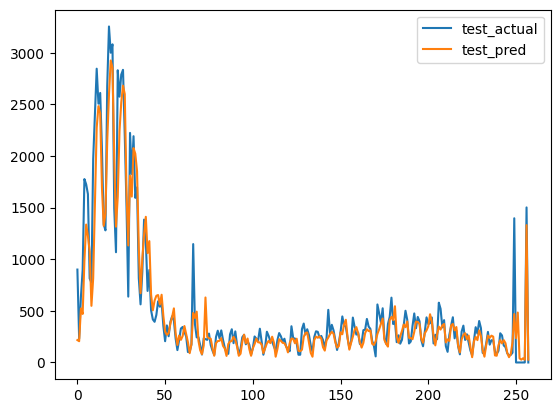

In [ ]:
# visualization
pd.concat([y_test.loc[test.location_key_x == 'US_AK'], y_test_pred2_series.loc[test.location_key_x == 'US_AK']], axis=1).plot()
plt.legend(['test_actual', 'test_pred'])

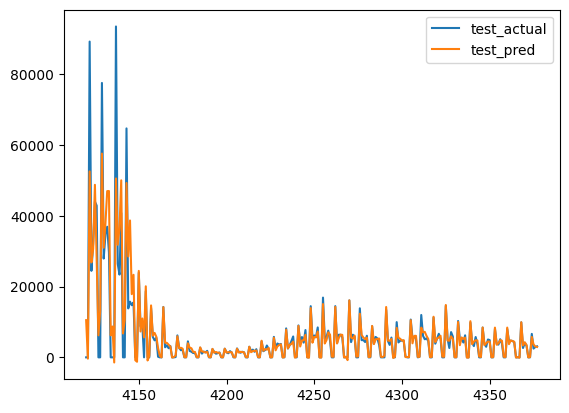

In [ ]:
# let's play with IL
pd.concat([y_test.loc[test.location_key_x == 'US_IL'], y_test_pred2_series.loc[test.location_key_x == 'US_IL']], axis=1).plot()
plt.legend(['test_actual', 'test_pred'])

Another attempt: make outlier vaccine numbers super big numbers

In [ ]:
X_train_sel.cumulative_persons_fully_vaccinated.max()

26105670.0

In [ ]:
X_train_sel.loc[train_by_date.date < '2020-12-11', ['new_persons_fully_vaccinated','cumulative_persons_fully_vaccinated']] = 26105670*100

In [ ]:
lgbm4 = LGBMRegressor(random_state=1, n_jobs=-1)
lgbm4.fit(X_train_sel, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4982
[LightGBM] [Info] Number of data points in the train set: 69913, number of used features: 34
[LightGBM] [Info] Start training from score 825.586314


LGBMRegressor(n_jobs=-1, random_state=1)

In [ ]:
# train and test rmse
y_train_pred4 = lgbm4.predict(X_train_sel)
y_test_pred4 = lgbm4.predict(X_test_sel)
print("The training rmse is ", mean_squared_error(y_train, y_train_pred4, squared = False))
print("The testing rmse is ", mean_squared_error(y_test, y_test_pred4, squared = False))

The training rmse is  356.1737095248507
The testing rmse is  3857.56811800029


In [ ]:
feature_importance_table4 = pd.DataFrame(data = [lgbm4.feature_name_, lgbm4.feature_importances_]).T
feature_importance_table4.columns = ['feature', 'importance']
feature_importance_table4.sort_values(by = 'importance', ascending = False, inplace = True)
feature_importance_table4.reset_index()

,index,feature,importance
0,14,new_confirmed_lag1,280
1,0,new_deceased,231
2,17,new_confirmed_mean3,222
3,16,new_confirmed_lag7,221
4,19,new_confirmed_std3,218
5,25,day_of_week,199
6,23,new_confirmed_min3,191
7,21,new_confirmed_max3,182
8,15,new_confirmed_lag3,175
9,8,mobility_workplaces,149
